In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm
from pathlib import Path
from collections import Counter

In [4]:
transcript_dir = Path("data")
df = pd.read_csv(transcript_dir / "transcripts_normalized.csv", header=0)
df.dropna(subset=["transcript"], inplace=True)
df.head()

video_id                                         transcript
0  AAHiZ-c88ec  man im getting frustrated water heater deliver...
1  AEsRr-ZnzNc  start give shout rokukun vyonder harrystack go...
2  AJpzk-aFZPU  10 minute test number exploding apple alright ...
3  AONXX-h9SdI  gonna play something brand new album came octo...
5  APerX-RLJxo  2010 toyota corolla fourdoor sedan automatic t...

In [5]:
def get_kmeans_clusters(X_embeddings: np.ndarray, n_clusters: int = 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_embeddings)
    return kmeans

In [6]:
def plot_pca(km, X_embeddings: np.ndarray, title, save=True):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_embeddings)
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Label")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    if save:
        plt.savefig(f"figures/emb_baseline_pca_{title}.png")
    plt.show()

In [7]:
cluster_sizes = list(range(10, 51))
df_all = df.copy()
df_less_than_100 = df[df["transcript"].str.split().str.len() < 100]
df_more_than_100 = df[df["transcript"].str.split().str.len() >= 100]

df_corporas = [df_all, df_less_than_100, df_more_than_100]
print(df_corporas[0].shape)
print(df_corporas[1].shape)
print(df_corporas[2].shape)

(2316, 2)
(1142, 2)
(1174, 2)


In [8]:
measures = [[], [], []]
kms = [[], [], []]

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# save embeddings once
print("Embedding transcripts...")
df_embeddings = []
for df_corpus in tqdm(df_corporas):
    embeddings = model.encode(df_corpus["transcript"].to_list(), convert_to_numpy=True)
    df_embeddings.append(embeddings)

print("Clustering transcripts...")
for n_clusters in tqdm(cluster_sizes):
    for i, df_corpus in enumerate(df_corporas):
        km = get_kmeans_clusters(df_embeddings[i], n_clusters)
        kms[i].append(km)
        measures[i].append({
            "n_clusters": n_clusters,
            "inertia": km.inertia_,
            "silhouette_score": silhouette_score(df_embeddings[i], km.labels_),
            "davies_bouldin_score": davies_bouldin_score(df_embeddings[i], km.labels_),
            "calinski_harabasz_score": calinski_harabasz_score(df_embeddings[i], km.labels_)
        })

Embedding transcripts...


100%|██████████| 3/3 [01:54<00:00, 38.25s/it]


Clustering transcripts...


  0%|          | 0/41 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/envs/ytb/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 41/41 [00:38<00:00,  1.07it/s]


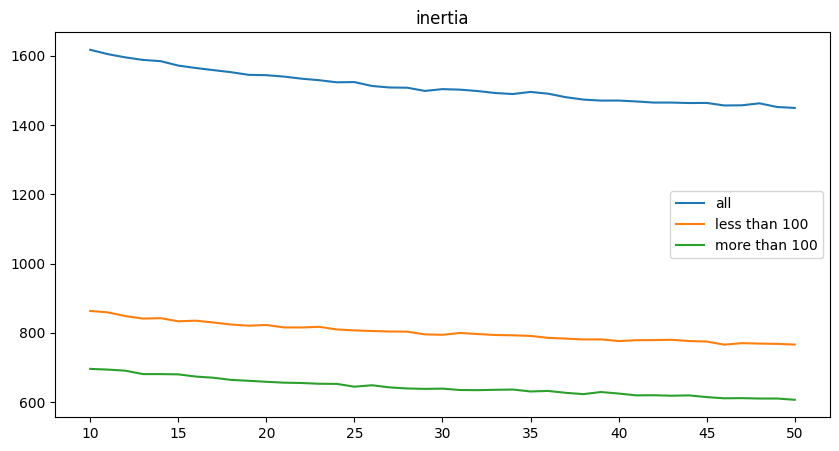

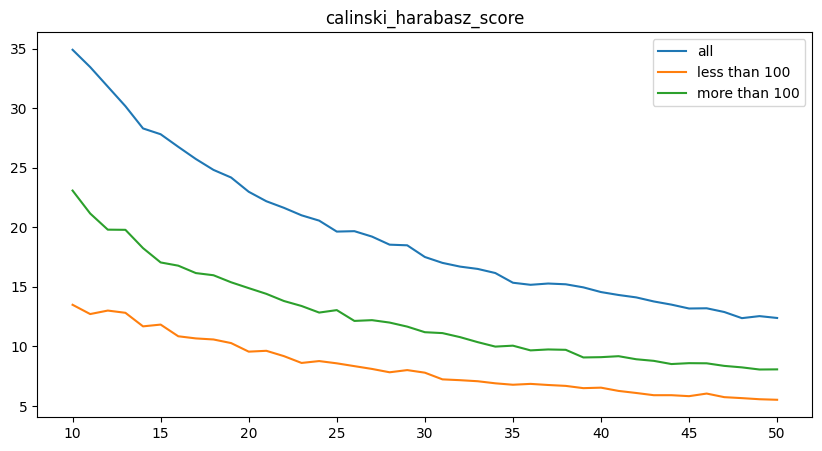

In [9]:
plot_attributes = ["inertia", "silhouette_score", "davies_bouldin_score", "calinski_harabasz_score"]
labels = ["all", "less than 100", "more than 100"]
for attribute in plot_attributes:
    plt.figure(figsize=(10, 5))
    for i, df_corpus in enumerate(df_corporas):
        plt.plot(cluster_sizes, [m[attribute] for m in measures[i]], label=labels[i])
        plt.title(attribute)
    plt.legend()
    plt.savefig(f"figures/emb_baseline_measure_{attribute}.png")
    plt.show()

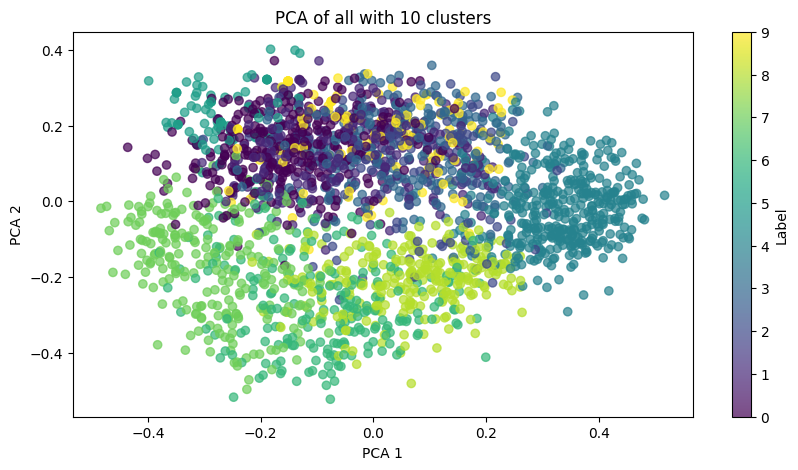

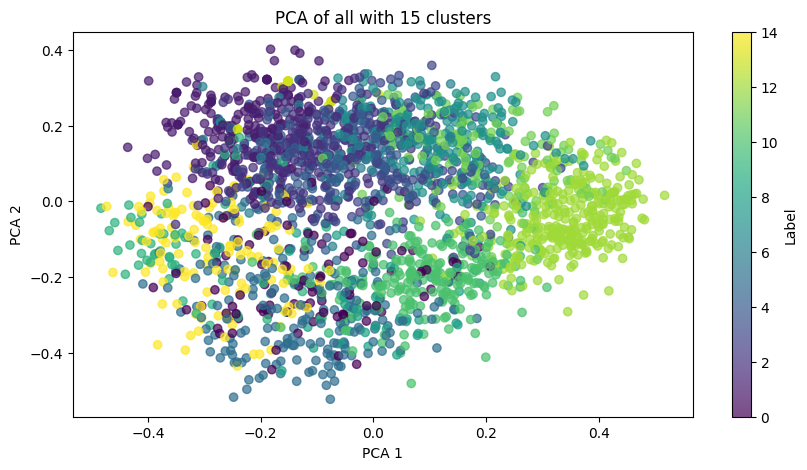

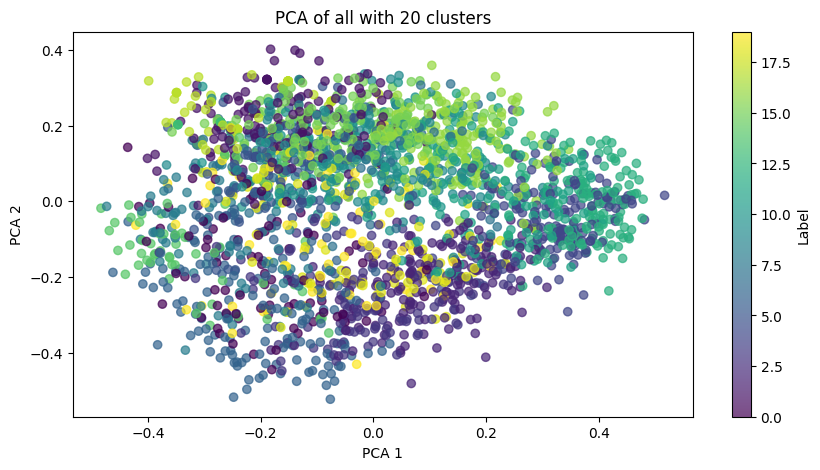

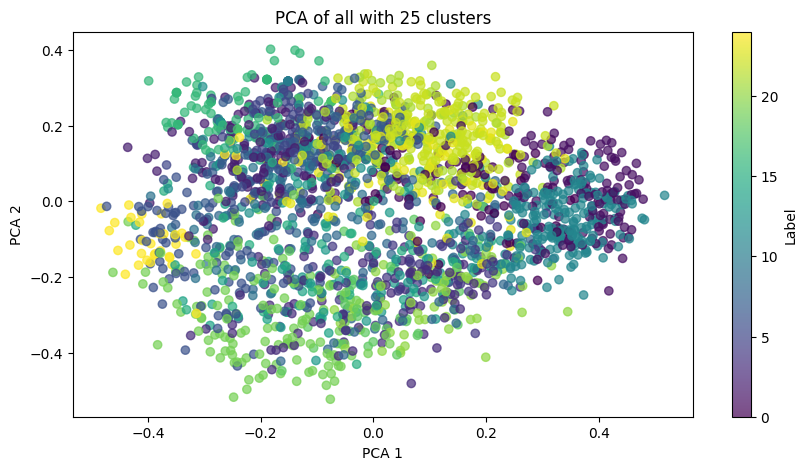

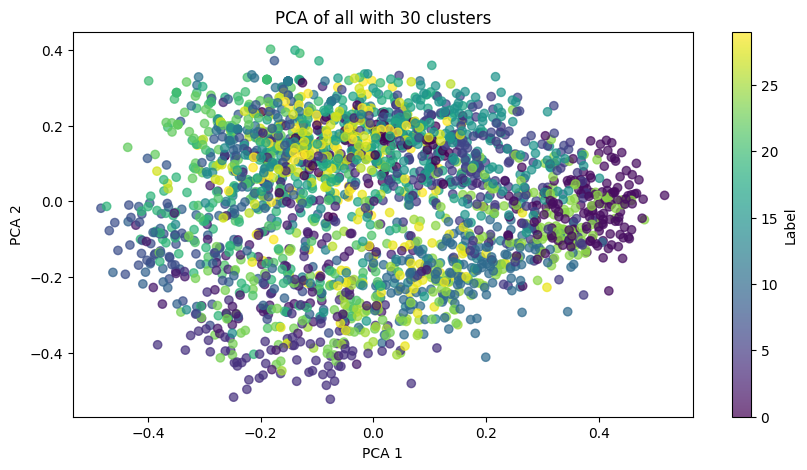

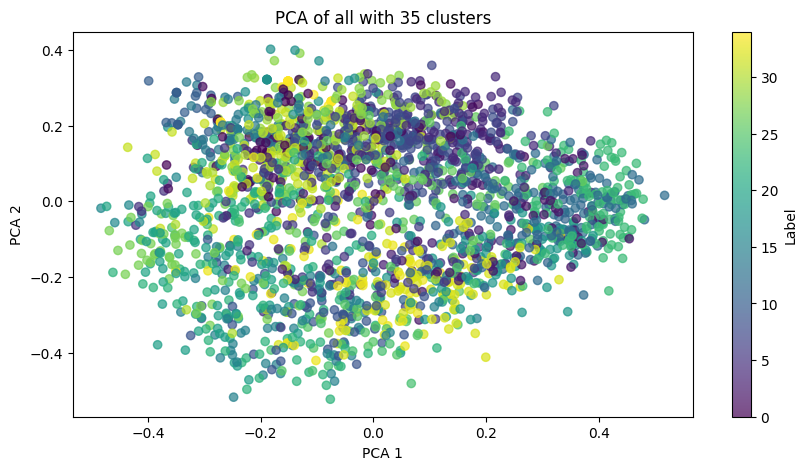

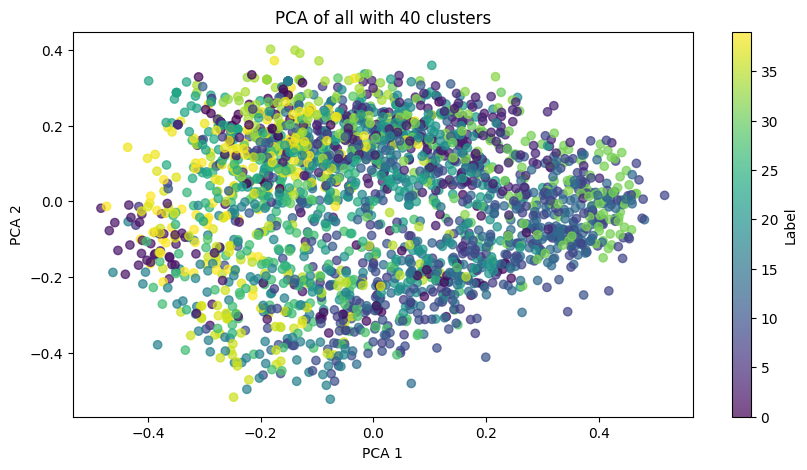

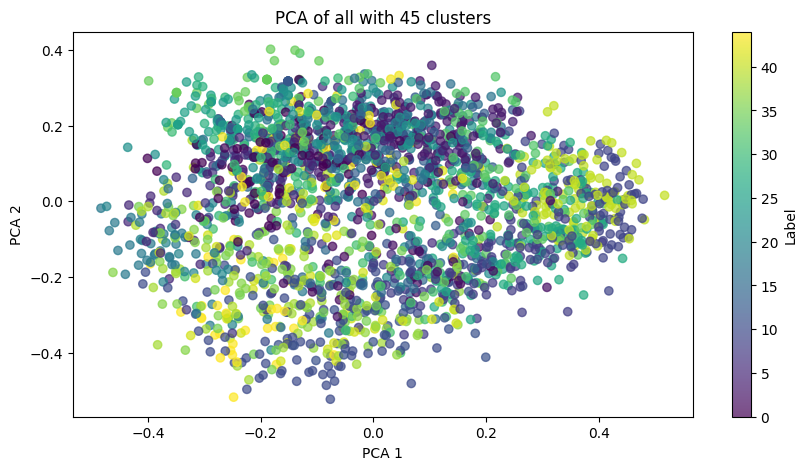

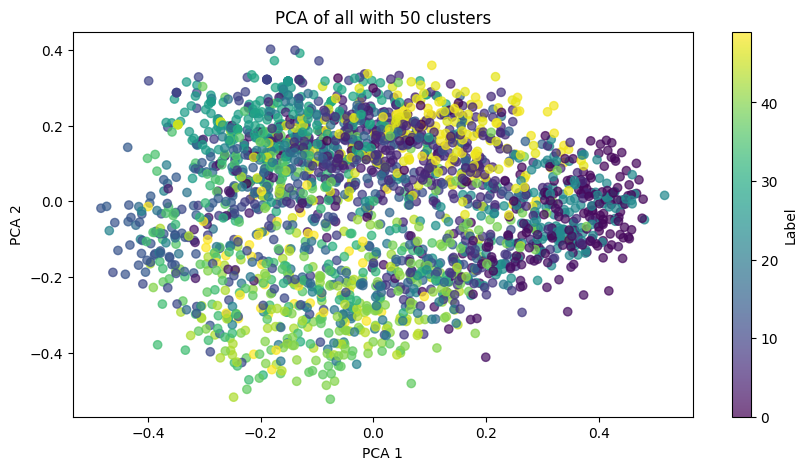

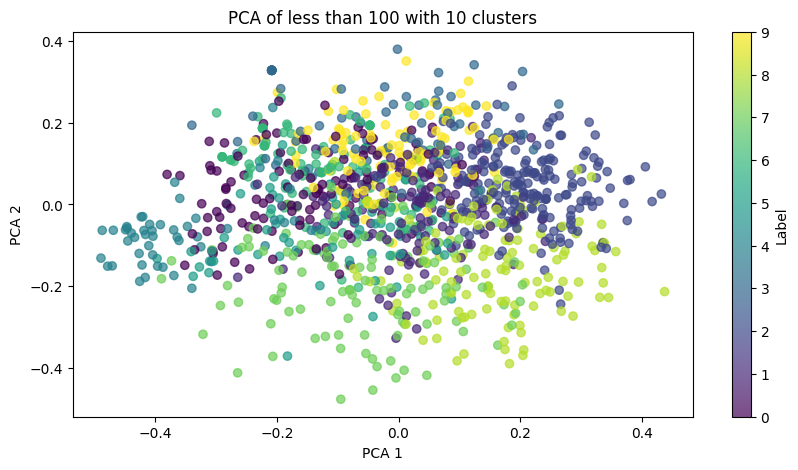

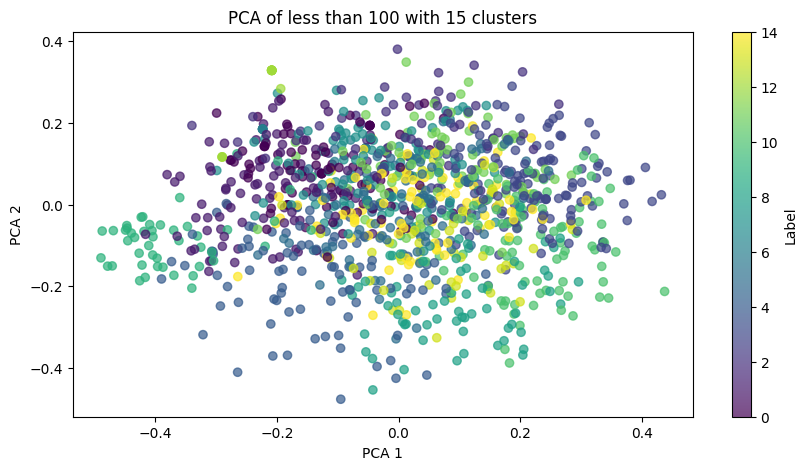

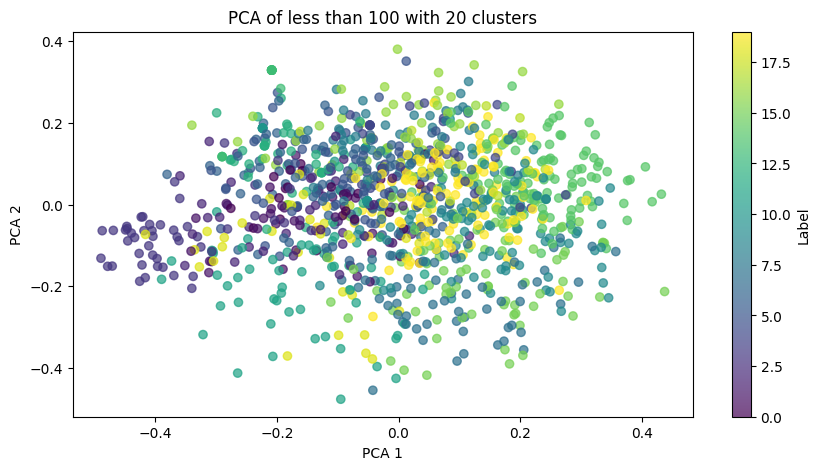

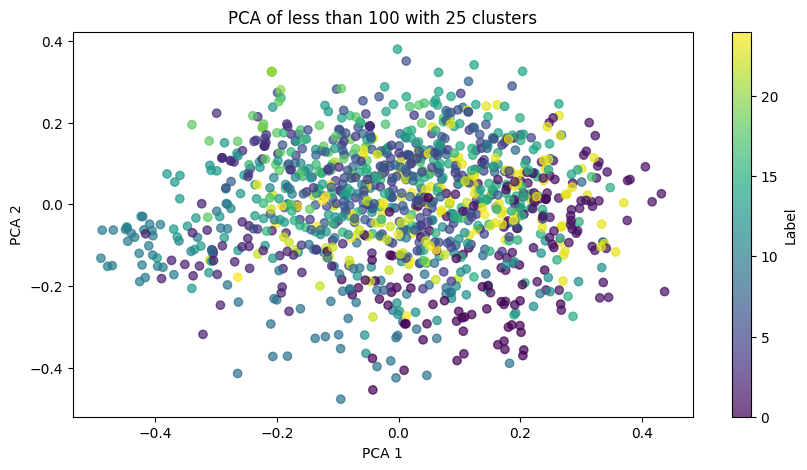

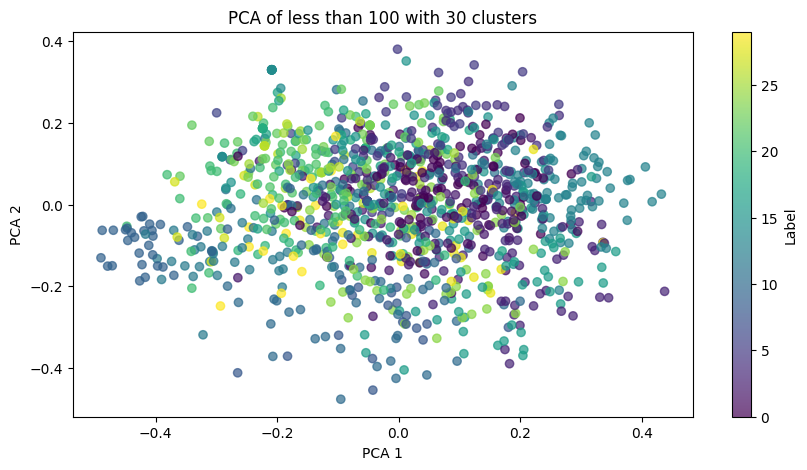

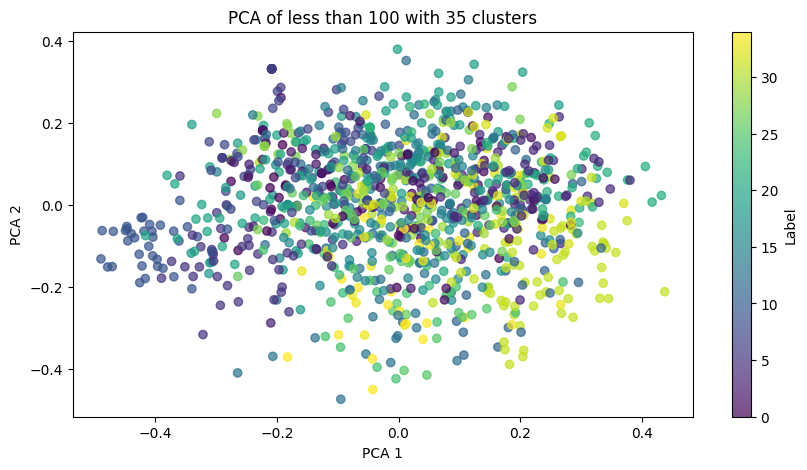

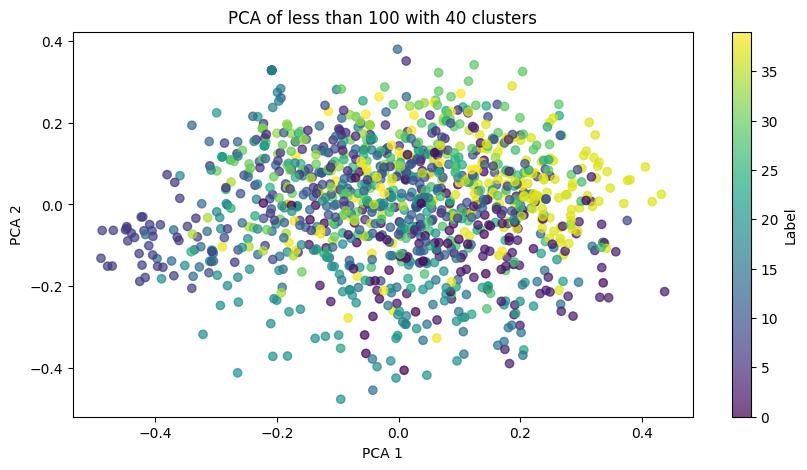

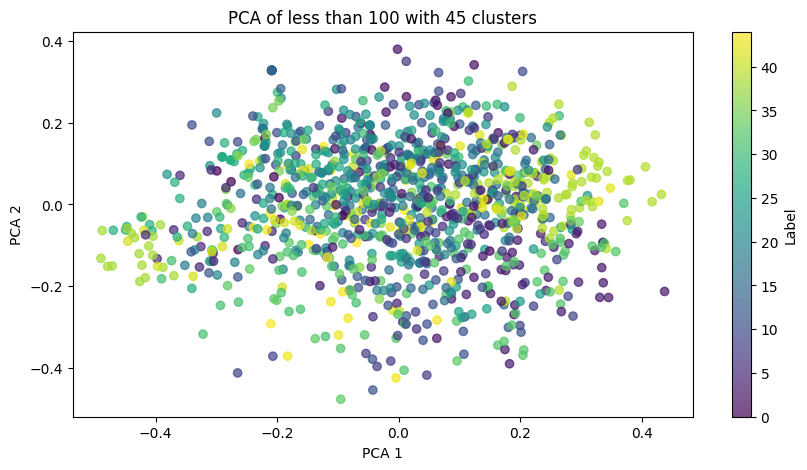

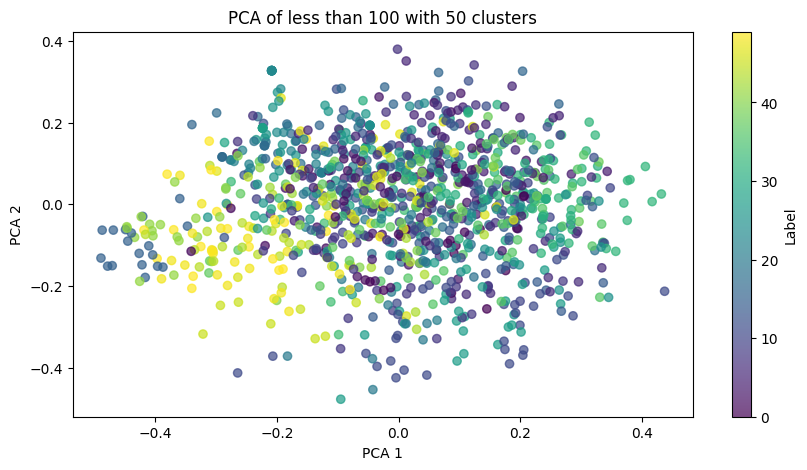

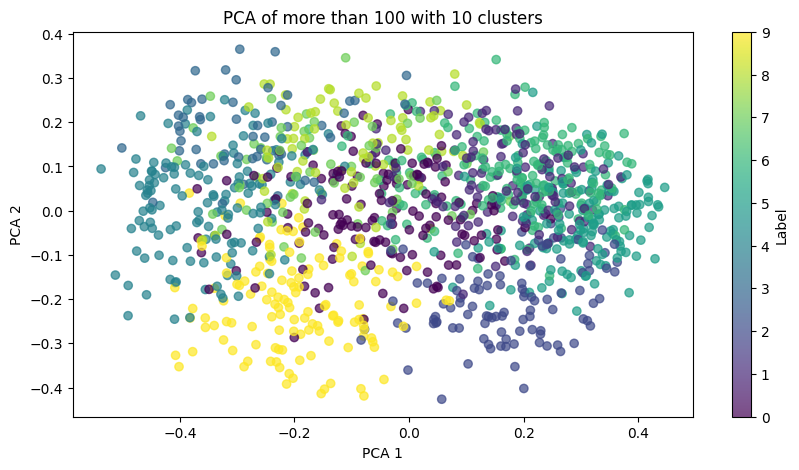

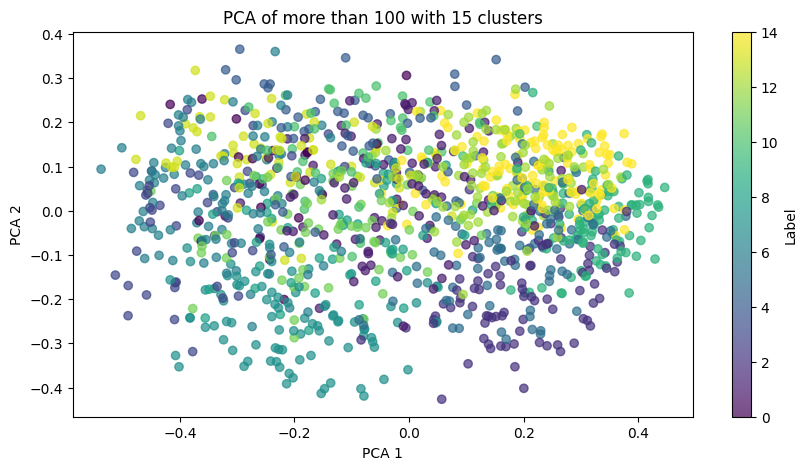

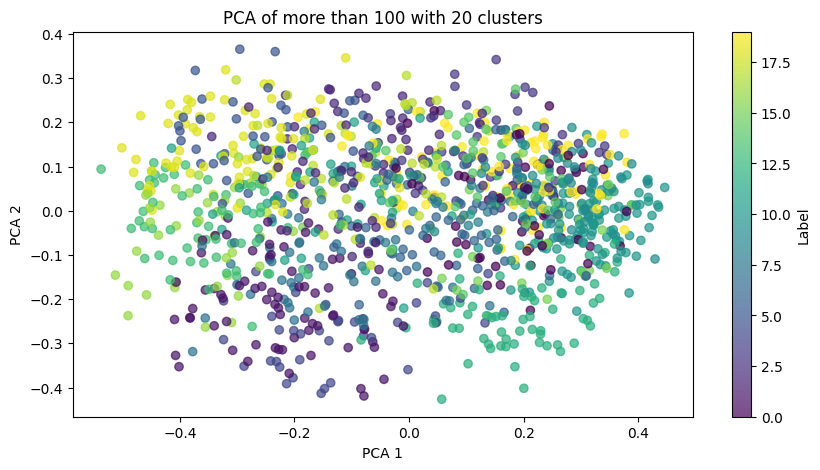

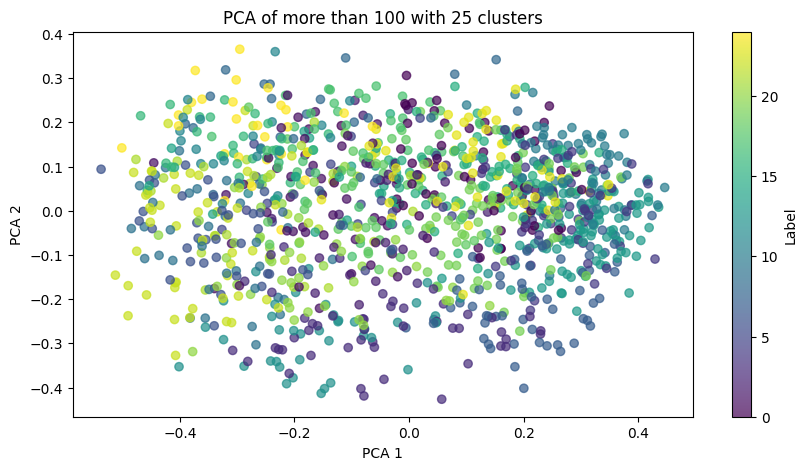

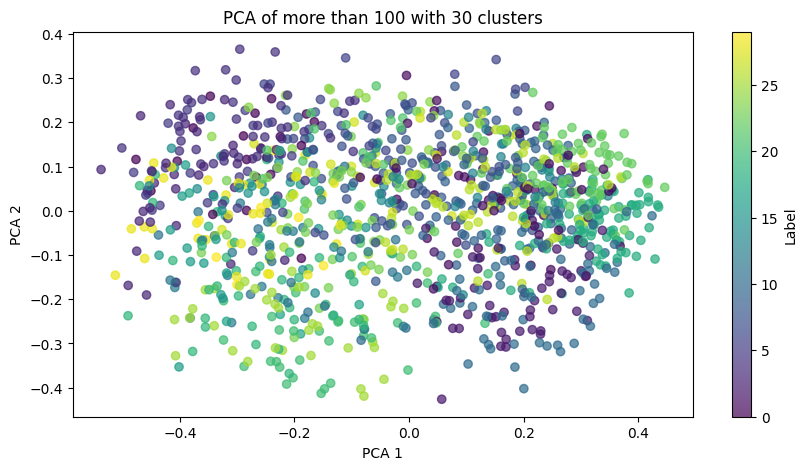

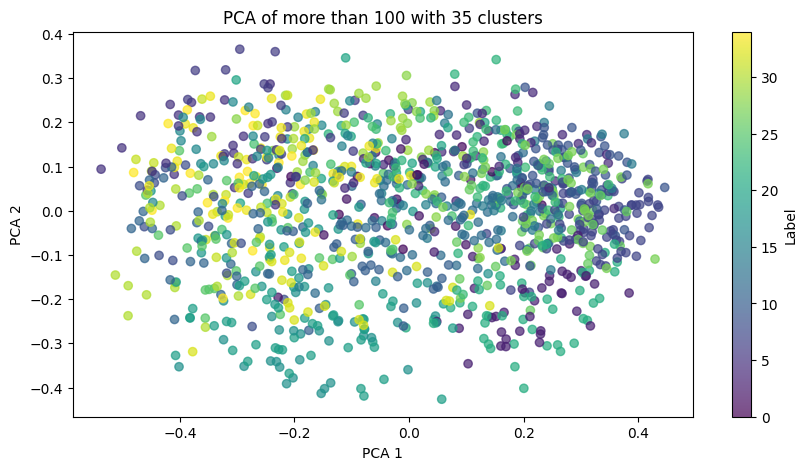

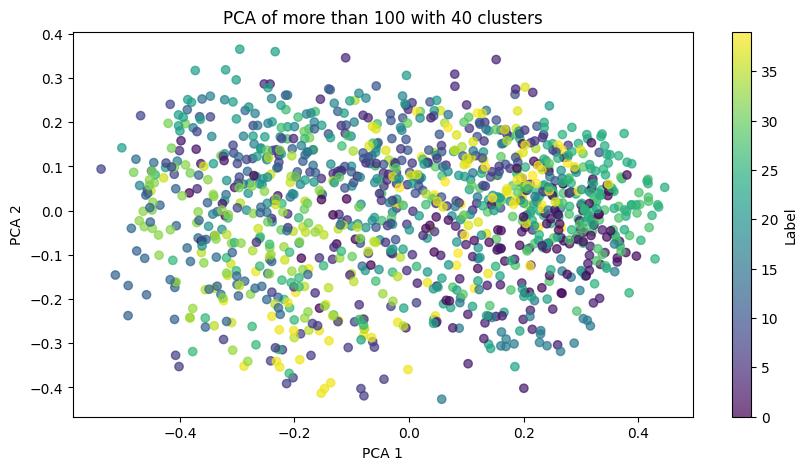

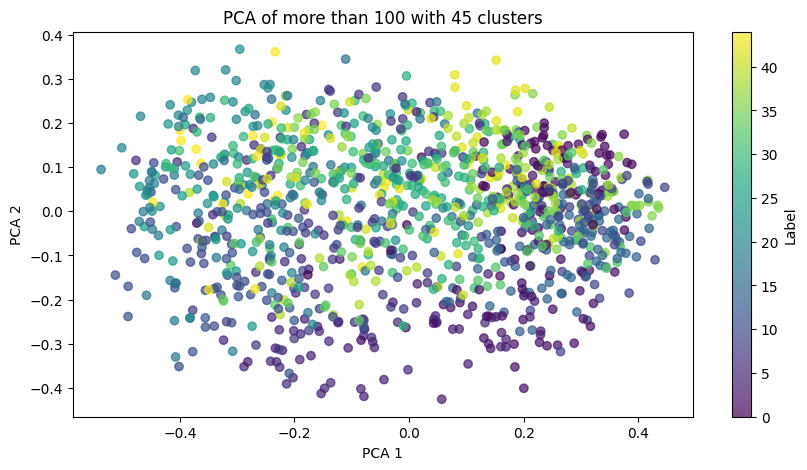

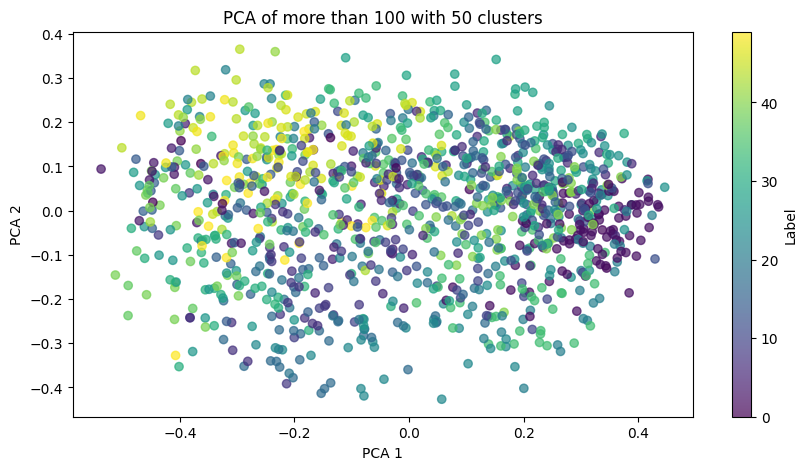

In [10]:
for i, km in enumerate(kms):
    for j, k in enumerate(km):
        if j % 5 == 0:
            plot_pca(k, df_embeddings[i], f"PCA of {labels[i]} with {cluster_sizes[j]} clusters")

In [17]:
kms[0][35].labels_.shape, kms[0][35]

((2316,), KMeans(n_clusters=45))

In [18]:
km_topk = kms[0][35]
n_words = 10
cluster_words = []
for i in range(km_topk.n_clusters):
    cluster_mask = km_topk.labels_ == i
    cluster_docs = df_corporas[0][cluster_mask]["transcript"].tolist()
    
    words = " ".join(cluster_docs).split()
    word_freq = Counter(words)
    
    top_words = word_freq.most_common(n_words)
    cluster_words.append(top_words)
    
    print(f"\nCluster {i} top {n_words} words:")
    for word, count in top_words:
        print(f"{word}: {count}")



Cluster 0 top 10 words:
im: 34
baltimore: 24
born: 24
know: 23
like: 22
thats: 22
he: 21
right: 20
oh: 18
one: 16

Cluster 1 top 10 words:
like: 539
im: 473
going: 239
really: 218
little: 207
one: 186
dont: 172
bit: 170
know: 163
look: 154

Cluster 2 top 10 words:
like: 125
know: 121
one: 93
really: 91
im: 72
see: 71
got: 68
get: 64
going: 57
think: 54

Cluster 3 top 10 words:
im: 201
thats: 141
dont: 94
like: 89
get: 85
gonna: 79
go: 71
know: 63
got: 57
oh: 49

Cluster 4 top 10 words:
happy: 220
bop: 134
video: 108
oh: 98
youre: 80
color: 79
time: 78
circuit: 66
good: 64
christmas: 57

Cluster 5 top 10 words:
today: 224
im: 53
go: 44
going: 38
click: 38
got: 34
let: 33
one: 26
okay: 23
next: 21

Cluster 6 top 10 words:
im: 49
love: 45
get: 33
day: 33
oh: 31
time: 30
see: 28
right: 27
good: 24
going: 24

Cluster 7 top 10 words:
like: 99
little: 56
add: 54
going: 52
nutmeg: 49
make: 48
bit: 47
good: 45
bye: 40
get: 38

Cluster 8 top 10 words:
im: 1138
like: 1133
get: 645
know: 638
goin